# Patient CC

**Author:** Ximena Fernandez

In this notebook we present the analysis of the time series derived from iEEG recordings, using methods from TDA.

### The data

The dataset is the iEEG recording of the brain activity for 9 channels (regions) of the patient CC (Toronto Western Hospital).

In [54]:
from scipy.io import loadmat

data = loadmat('data/row_data_CC_sezure_intra_0134.mat')['M_rdata_CC']
data = data[580000:640000, :].T

In [2]:
n_electrodes = data.shape[0]             # rows (i.e. electrodes) in the data matrix
n_samples = data.shape[1]                  # number of samples on each row (i.e. electrode's samples)
electrode_names = ['Channel %i'%(channel) for channel in range(n_electrodes)]   # name or labels of the electrodes
t = range(n_samples)

We plot the segment of the recording that contains the preictal and ictal states.

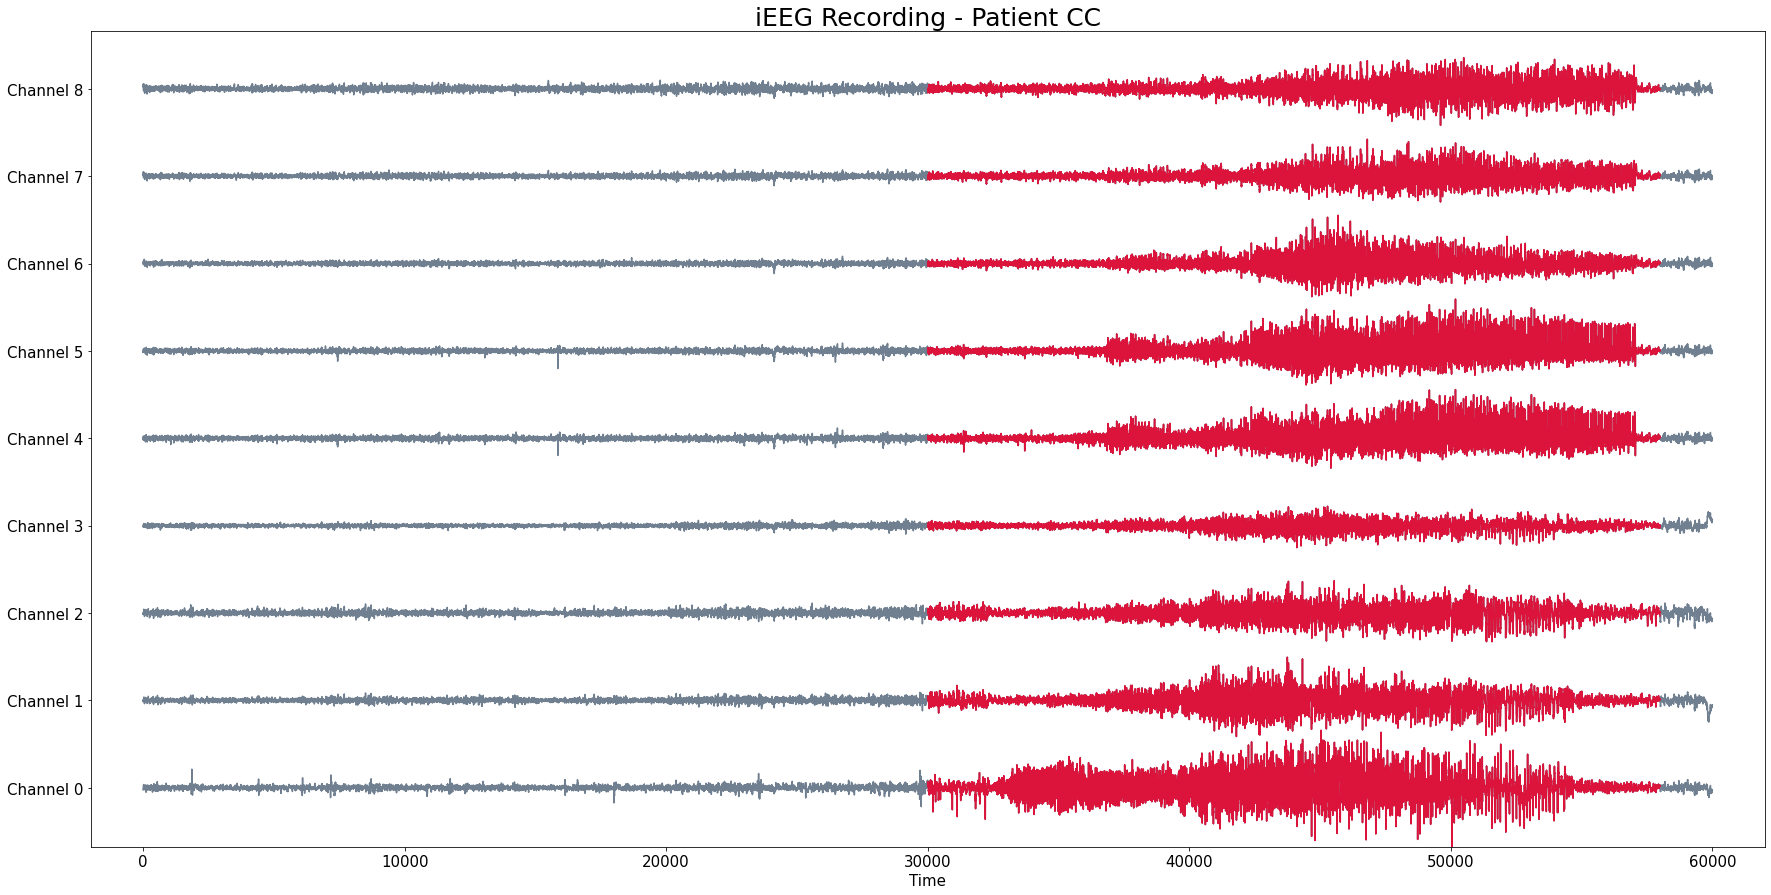

In [10]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy             as np

fig = plt.figure("EEG samples",figsize=(30,15))

ticklocs = []
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(-2000, n_samples+2000)
plt.xticks(fontsize=15)
data_min = data.min()
data_max = data.max()
dr = (data_max - data_min) * 0.75   #crowd it a bit
y0 = data_min
y1 = (n_electrodes -1) * dr + data_max
ax.set_ylim(y0, y1)

segs = []
for electrode in range(n_electrodes):
    segs.append(np.column_stack((t, data[electrode, :])))
    ticklocs.append(electrode * dr)
    
offsets = np.zeros((n_electrodes, 2), dtype=float)
offsets[:, 1] = ticklocs

lines = LineCollection(segs, offsets=offsets, transOffset=None, color = 'slategrey')
ax.add_collection(lines);

segs_red = []
for electrode in range(n_electrodes):
    segs_red.append(np.column_stack((range(30000,58000), data[electrode, 30000:58000])))

lines_red = LineCollection(segs_red, offsets=offsets, transOffset=None, color = 'crimson')
ax.add_collection(lines_red);

# Set the yticks to use axes coordinates on the y axis
ax.set_yticks(ticklocs)
ax.set_yticklabels(electrode_names, fontsize = 15)
plt.title('iEEG Recording - Patient CC', fontsize = 25)
ax.set_xlabel('Time', fontsize = 15)
plt.savefig('figures/CC_iEEG_seizure.png');
plt.show();

We observe in red the interval of the epileptic seizure, according to the diagnostic of the doctor.

### Sliding Window Embedding

We compute the joint embedding of the signals $X_1, X_2, \dots X_N$ in the Euclidean space, to obtain a point cloud in $\mathbb {R}^N$
$$
\left\{(X_1(t), X_2(t), \dots X_N(t))\colon t \in [0,T]\right\}
$$

![alt text](figures/iEEG_embedding.png "iEEG Patient CC")

We compute the embedding of a sliding window restriction of the embedding, to campute local changes in the dynamics. Given $W$ the **size of the window**, the sliding window embedding at $t\in [W, T]$ is 
$$
X_W(t) = \left\{(X_1(s), X_2(s), \dots X_N(s))\colon s \in [t-W,t]\right\}
$$

![alt text](figures/CC_iEEG_window.png "iEEG Patient CC")

The **evolution** of the topology of the embedding can be captured by means of the persistent homology of the sliding window embedding, with $t$ running along all the interval $[W, T]$.

In [22]:
from ripser import Rips

rips = Rips()
dgms = {}
window_persistence_diagrams = {}
window_persistence_diagrams[0] = {}
window_persistence_diagrams[1] = {}
step = 100
window_size = 1000

for i, t in enumerate(np.arange(window_size, 60100, step)):
    window = data.T[t-window_size: t, :]
    diagram = rips.fit_transform(window)
    dgms[i] = diagram
    window_persistence_diagrams[0][t] = diagram[0]
    window_persistence_diagrams[1][t] = diagram[1]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


The following animation shows the evolution of the persistent diagrams associated to the sliding window embeddings.

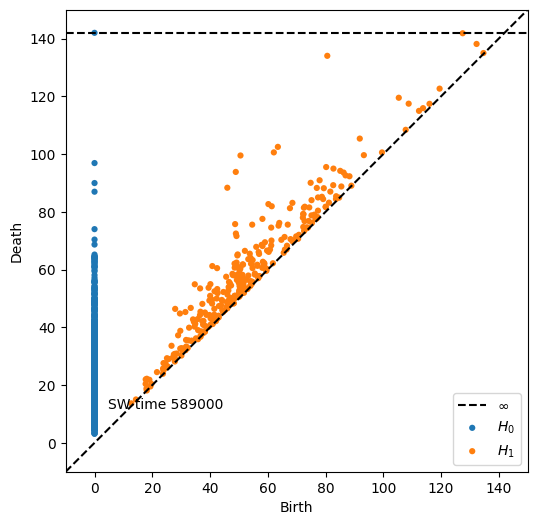

In [42]:
from   matplotlib import animation, rc
import persim
from IPython.display import HTML

fig = plt.figure( figsize=(6,6) )   
ax = fig.add_subplot(1, 1, 1)           

def animate_dgm(i):
    ax.clear()
    persim.plot_diagrams(dgms[i], xy_range=[-10, 150,-10,150])
    time = i*1000
    ax.text(4.8, 11.8, 'SW time %i'%time)    
    
anim = animation.FuncAnimation(fig, animate_dgm,
                               frames=590,
                               interval=400,
                               blit=False,
                               repeat=False)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

anim.save('figures/animation_PD.mp4', writer = writer, dpi=150)

HTML(anim.to_html5_video()) 

### Consecutive Wasserstein distance

In order to quantify the local changes in the topology of the embedding along the time interval, we compute the **Wasserstein distance** between the consecutive persistent diagrams in a sample $t_1, t_2, \dots, t_n\in [W, T]$:

$$
\dfrac{d_W\Big(\mathrm{dgm}\big(X_W(t_i)\big), \mathrm{dgm}\big(X_W(t_{i+1})\big)\Big)}{|t_i-t_{i+1}|}
$$
This is an estimator of the first derivative of $\mathrm{dgm}(X_W(t))$.

In [44]:
import warnings
warnings.filterwarnings("ignore")

w_wasserstein = {}
for i in range(2):
    w_wasserstein[i] = {}
for i in range(2):
    for t in list(window_persistence_diagrams[0].keys())[1:]:
        w_wasserstein[i][t] = persim.wasserstein(window_persistence_diagrams[i][t], window_persistence_diagrams[i][t-step])

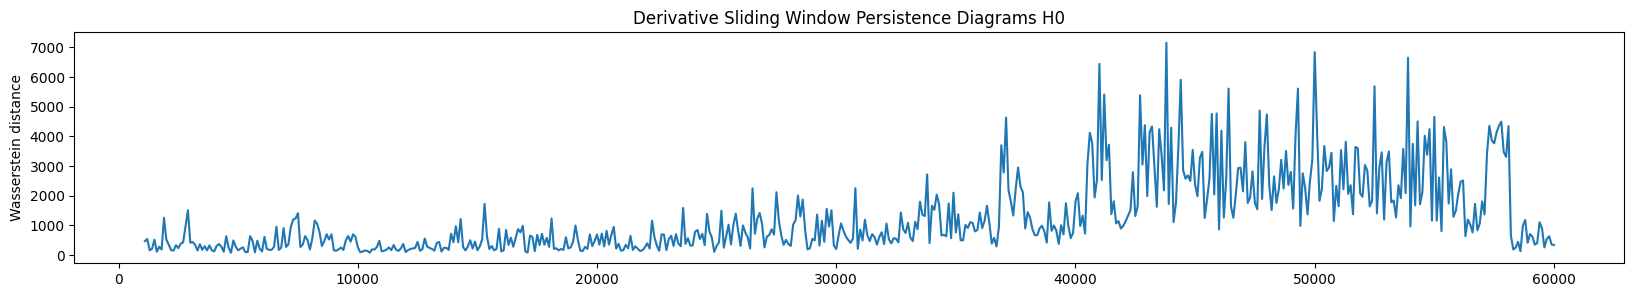

In [45]:
fig = plt.figure(figsize=(20,3))

plt.plot(list(window_persistence_diagrams[0].keys())[1:], w_wasserstein[0].values());
plt.ylabel('Wasserstein distance')
plt.title('Derivative Sliding Window Persistence Diagrams H0')
plt.savefig('figures/SW_CC_consecutive_distance_H0.png')

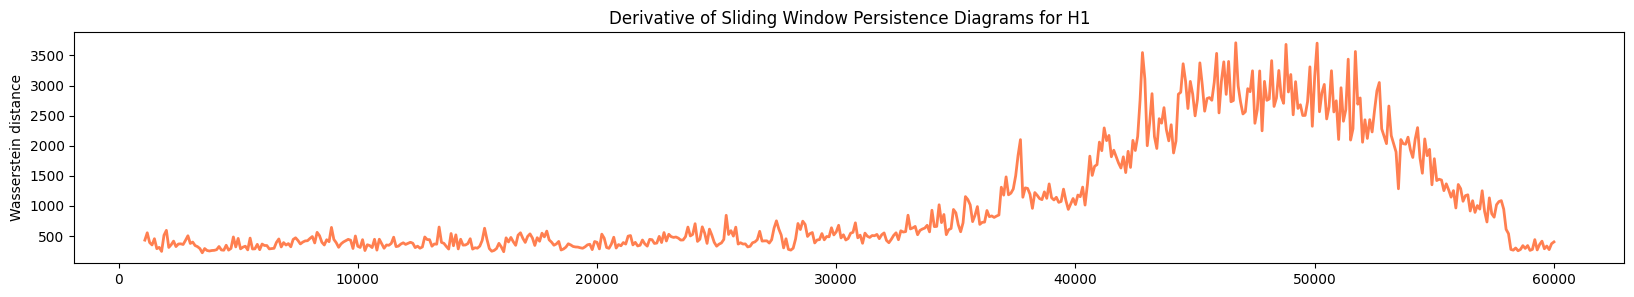

In [46]:
fig = plt.figure(figsize=(20,3))

plt.plot(list(window_persistence_diagrams[0].keys())[1:], w_wasserstein[1].values(), color = 'coral', lw = 2)
plt.ylabel('Wasserstein distance')
plt.title('Derivative of Sliding Window Persistence Diagrams for H1')
plt.savefig('figures/SW_CC_consecutive_distance_H1.png')

### Persistence summary functions

In addition  we compute a series of summary functions associated to $\mathrm{dgm}(X_W(t))$ for every $t\in [W, T]$, to track the evolution of different features associated to the persistent diagrams.

  - **Total persistence**

$$||\mathcal{D}||_1 = \sum_{(x,y) \in \mathcal{D}} pers(x,y)$$

  - **Standard deviation persistence**

$$\sigma(\mathcal{D}) = \text{Standard Deviation}\{pers(x,y): (x,y) \in \mathcal{D}\} $$

In [151]:
w_persistence = {}
w_std = {}
w_mean = {}
w_sum = {}
w_mean_death1 = {}

for i in range(2):
    w_persistence[i] = {}
    w_mean[i] = {}
    w_std[i] = {}  
    w_sum[i] = {}

for t in window_persistence_diagrams[0].keys():
    w_persistence[0][t] = np.sort(window_persistence_diagrams[0][t][:,1]-window_persistence_diagrams[0][t][:,0])[:-1]
    w_persistence[1][t] = np.sort(window_persistence_diagrams[1][t][:,1]-window_persistence_diagrams[1][t][:,0])
    w_mean_death1[t] = window_persistence_diagrams[1][t][:,1].mean()
    for i in range(2):
        w_mean[i][t] = w_persistence[i][t].mean()
        w_std[i][t] = w_persistence[i][t].std()
        w_sum[i][t] = w_persistence[i][t].sum()

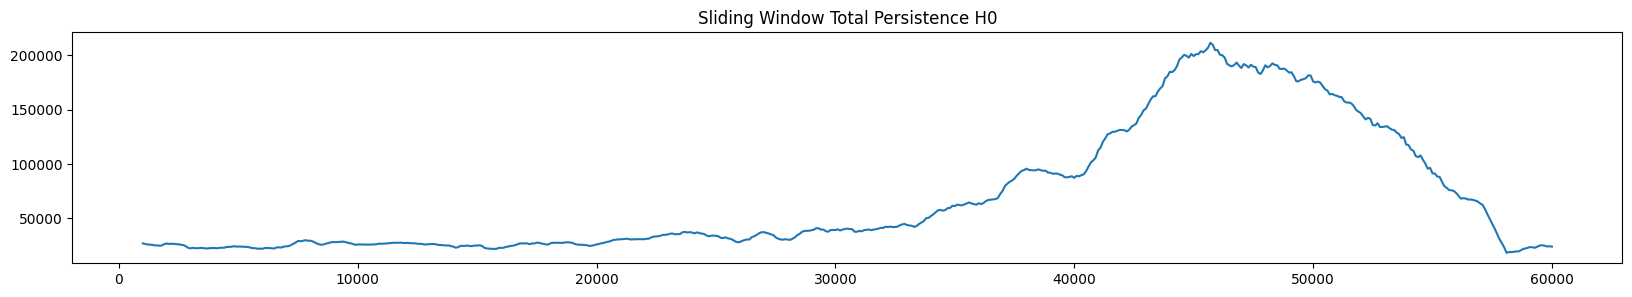

In [152]:
fig = plt.figure(figsize=(20,3))

plt.plot(window_persistence_diagrams[0].keys(), w_sum[0].values());
plt.title('Sliding Window Total Persistence H0');
plt.savefig('figures/SW_CC_total_persistence_H0.png')

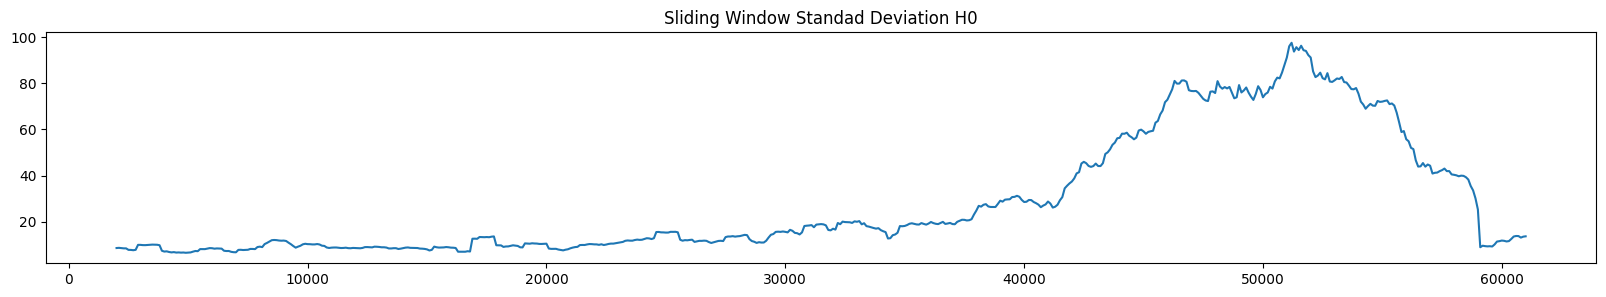

In [153]:
fig = plt.figure(figsize=(20,3))

plt.plot(np.array(list(window_persistence_diagrams[0].keys()))+1000, w_std[0].values());
plt.title('Sliding Window Standad Deviation H0');

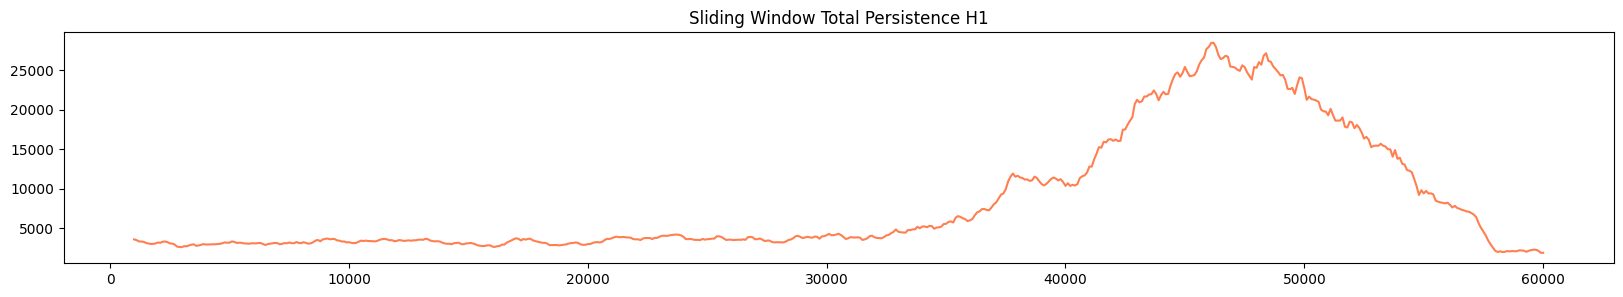

In [154]:
fig = plt.figure(figsize=(20,3))

plt.plot(np.array(list(window_persistence_diagrams[1].keys())), w_sum[1].values(), color = 'coral');
plt.title('Sliding Window Total Persistence H1');
plt.savefig('figures/SW_CC_total_persistence_H1.png')

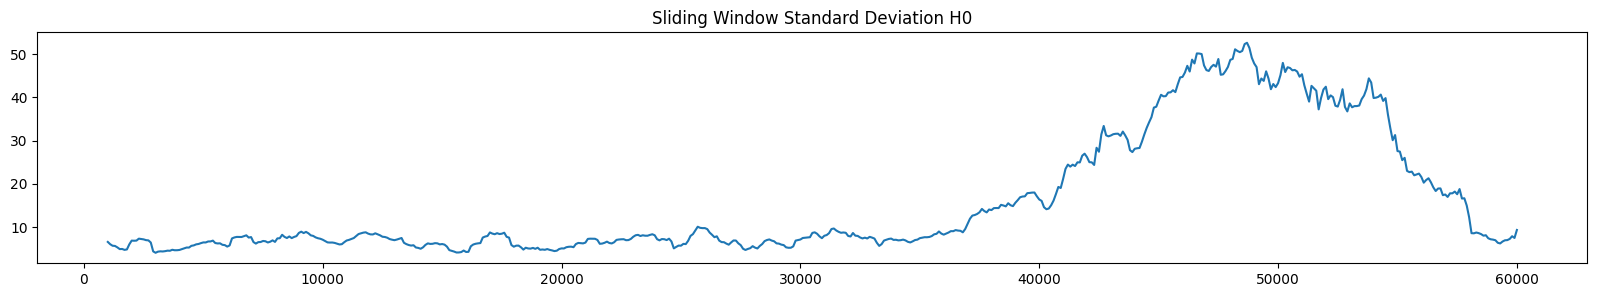

In [155]:
fig = plt.figure(figsize=(20,3))

plt.plot(np.array(list(window_persistence_diagrams[0].keys())), w_std[1].values());
plt.title('Sliding Window Standard Deviation H0');

  - **Persistent Entropy**
  
$$E(\mathcal{D}) = - \sum_{(x,y) \in \mathcal{D}} \frac{pers(x,y)}{L} \log\left(\frac{pers(x,y)}{L} \right)$$
where $L = \sum_{(x,y) \in \mathcal{D}}pers(x,y)$.

In [66]:
from gtda.diagrams import PersistenceEntropy
from gtda.homology import VietorisRipsPersistence
from scipy.spatial import distance_matrix

PE = PersistenceEntropy()
VR = VietorisRipsPersistence(homology_dimensions=[0, 1], metric = 'precomputed') 
entropy = {}
entropy[0] = {}
entropy[1] = {}

step = 100
window_size = 1000
start = 0
for t in np.arange(window_size, 60000, step):
    window = data.T[t-window_size:t, :]
    matrix = distance_matrix(window, window)
    diagram = VR.fit_transform(matrix[None, :,:])
    ent = PE.fit_transform(diagram)
    for i in range(2):
        entropy[i][t] = ent[0][i]

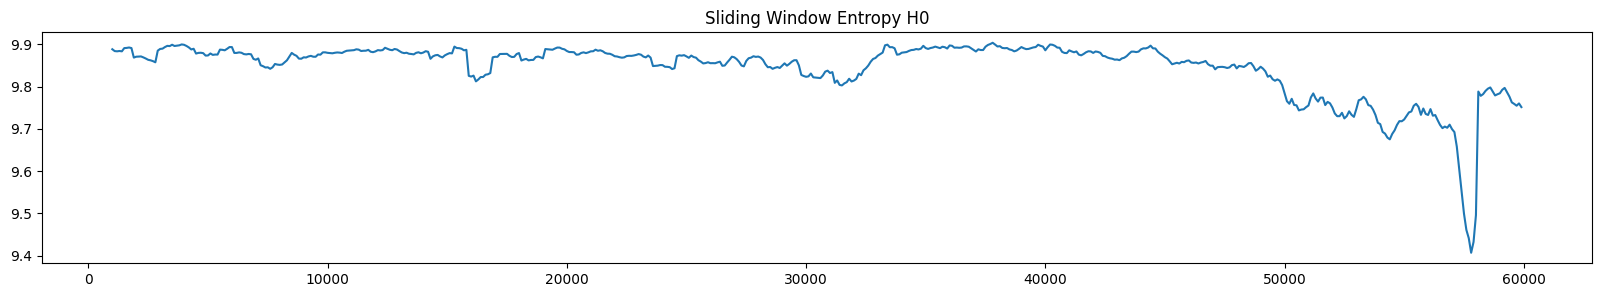

In [67]:
fig = plt.figure(figsize=(20,3))

plt.plot(np.array(list(entropy[0].keys())), entropy[0].values());
plt.title('Sliding Window Entropy H0');
plt.savefig('figures/SW_CC_entropy_H0.png')

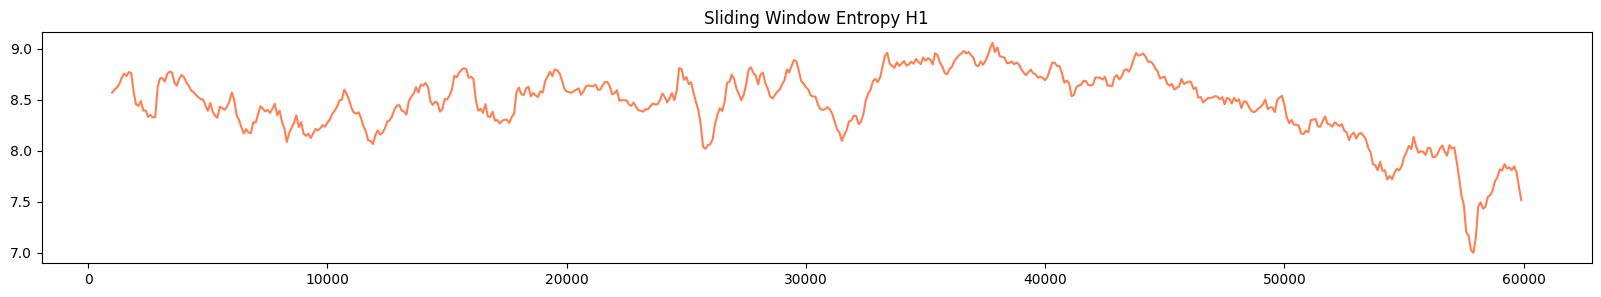

In [68]:
fig = plt.figure(figsize=(20,3))

plt.plot(np.array(list(entropy[1].keys())), entropy[1].values(),  color = 'coral');
plt.title('Sliding Window Entropy H1');
plt.savefig('figures/SW_CC_entropy_H1.png')

### Takens embedding & consecutive Wasserstein distance for every channel

In [71]:
w_wasserstein = {}
for i in range(2):
    w_wasserstein[i] = {}
    for channel in range(n_electrodes):
        w_wasserstein[i][channel]= {}

for i in range(2):
    for channel in range(n_electrodes):
        print(channel)
        for t in list(window_persistence_diagrams[0].keys())[1:]:
            w_wasserstein[i][channel][t] = persim.wasserstein(window_persistence_diagrams[i][t][channel], window_persistence_diagrams[i][t-step][channel])

0


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed